# Import Libraries

In [405]:
import pandas as pd, numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly_express as px

sns.set_style("whitegrid") # set some seaborn styles
#sns.set_style("ticks")

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_colwidth", 500)

# Import Data

In [406]:
df_raw = pd.read_csv("../data_raw/multiple_choice_responses_2019.csv", low_memory=False)

# 1. Review / cleaning 

In [407]:
df_raw["Q3"].value_counts()

India                                                   4786
United States of America                                3085
Other                                                   1054
Brazil                                                   728
Japan                                                    673
Russia                                                   626
China                                                    574
Germany                                                  531
United Kingdom of Great Britain and Northern Ireland     482
Canada                                                   450
Spain                                                    399
Nigeria                                                  395
France                                                   387
Taiwan                                                   301
Turkey                                                   288
Italy                                                    271
Australia               

In [408]:
# get overview, search isnull. 
100 * df_raw.isnull().sum() / len(df_raw)

Time from Start to Finish (seconds)     0.000000
Q1                                      0.000000
Q2                                      0.000000
Q2_OTHER_TEXT                           0.000000
Q3                                      0.000000
Q4                                      1.998174
Q5                                      3.093620
Q5_OTHER_TEXT                           0.000000
Q6                                     28.983670
Q7                                     30.905771
Q8                                     32.914089
Q9_Part_1                              69.104372
Q9_Part_2                              81.909930
Q9_Part_3                              74.733746
Q9_Part_4                              83.015519
Q9_Part_5                              81.204990
Q9_Part_6                              88.031240
Q9_Part_7                              97.301958
Q9_Part_8                              98.732123
Q9_OTHER_TEXT                           0.000000
Q10                 

As most cols are dummy vars we dont drop cols with hight perc isnull

In [409]:
df = df_raw.copy() 

In [410]:
# extract question
questions = df.iloc[0,:]

In [411]:
# drop questions
df = df.drop(df.index[0])

In [412]:
# check and drop duplicates
df = df.drop_duplicates()

In [413]:
# drop columns
## possible to drop later: Q16, Q17, Q20, Q30, Q31, Q32

drop_all = ["Q26", "Time from Start to Finish", "Q11", "Q19"]
#df[df.columns.drop(list(df.filter(regex="Q26", "OTHER", "Time from Start to Finish (seconds)", "Q11", "Q19")))]

for col in drop_all:
    df = df.loc[:,~df.columns.str.contains(col)]
    

In [414]:
rename = {"Q1" : "age",
          "Q2" : "gender",
          "Q3" : "country",
          "Q4" : "degree",
          "Q5" : "position",
          "Q6" : "company_size",
          "Q7": "team_size",
          "Q8": "ml_business(y/n)",
          "Q9_Part_1": "wa_bi_analysis",
          "Q9_Part_2": "wa_data_engineering",
          "Q9_Part_3": "wa_ml_prototyping",
          "Q9_Part_4": "wa_ml_service",
          "Q9_Part_5": "wa_ml_improvement",
          "Q9_Part_6": "wa_ml_research",
          "Q9_Part_7": "wa_none",
          "Q9_Part_8": "wa_other",
          "Q10": "salary(yrl)",
          "Q11": "cc_ml_expenses",
          "Q12_Part_1": "ds_media_twitter",
          "Q12_Part_2": "ds_media_hacker_news",
          "Q12_Part_3": "ds_media_reddit",
          "Q12_Part_4": "ds_media_kaggle",
          "Q12_Part_5": "ds_media_course_forums",
          "Q12_Part_6": "ds_media_youtube",
          "Q12_Part_7": "ds_media_podcasts",
          "Q12_Part_8": "ds_media_blogs",
          "Q12_Part_9": "ds_media_pub_jornals",
          "Q12_Part_10": "ds_media_slack",
          "Q12_Part_11": "ds_media_none",
          "Q12_Part_12": "ds_media_other",
          }
df = df.rename(columns=rename)

# 2. Extract subsets
for further steps we extract the relevant countries

In [415]:
india = df[df["country"] == "India"]

In [416]:
usa = df[df["country"] == "United States of America"]

## 2.1 some plotting

In [417]:
def perc(df, col):
    return round(100 * df[col].value_counts(normalize=True),2).to_frame()

In [418]:
global_gender_dist = perc(df, "gender").rename(columns={"gender" : "global"})
india_gender_dist = perc(india, "gender").rename(columns={"gender" : "india"})
usa_gender_dist = perc(usa, "gender").rename(columns={"gender" : "usa"})

df_gender = global_gender_dist.merge(right=india_gender_dist, how="inner", left_index=True, right_index=True)
df_gender= df_gender.merge(right=usa_gender_dist, how="inner", left_index=True, right_index=True)
df_gender

,global,india,usa
Male,81.84,82.69,77.37
Female,16.29,16.12,20.23
Prefer not to say,1.61,1.13,1.98
Prefer to self-describe,0.25,0.06,0.42


### 2.1.0 Fig Standards

In [419]:
figure_size = (12,6)

### 2.1.1 Gender

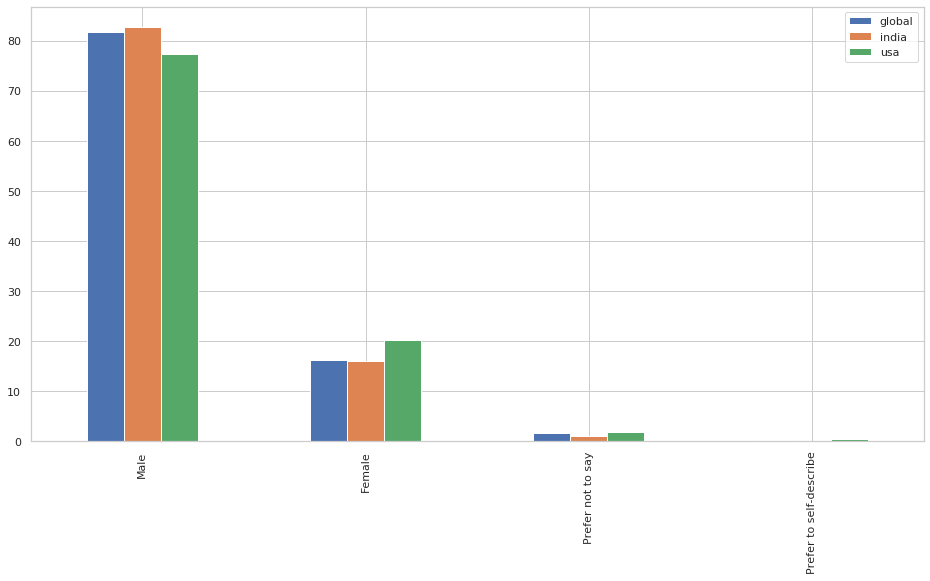

In [420]:
fig, ax = plt.subplots(figsize=(16, 8))
df_gender.plot(kind="bar", ax=ax);

### 2.1.2 Age

In [421]:
global_age_dist = perc(df, "age").rename(columns={"age" : "global"})
india_age_dist = perc(india, "age").rename(columns={"age" : "india"})
usa_age_dist = perc(usa, "age").rename(columns={"age" : "usa"})

df_age = global_age_dist.merge(right=india_age_dist, how="inner", left_index=True, right_index=True)
df_age = df_age.merge(right=usa_age_dist, how="inner", left_index=True, right_index=True)
df_age = df_age.reset_index()
df_age = df_age.rename(columns={"index": "age"}).sort_values(by="age")
df_age = df_age.set_index("age")

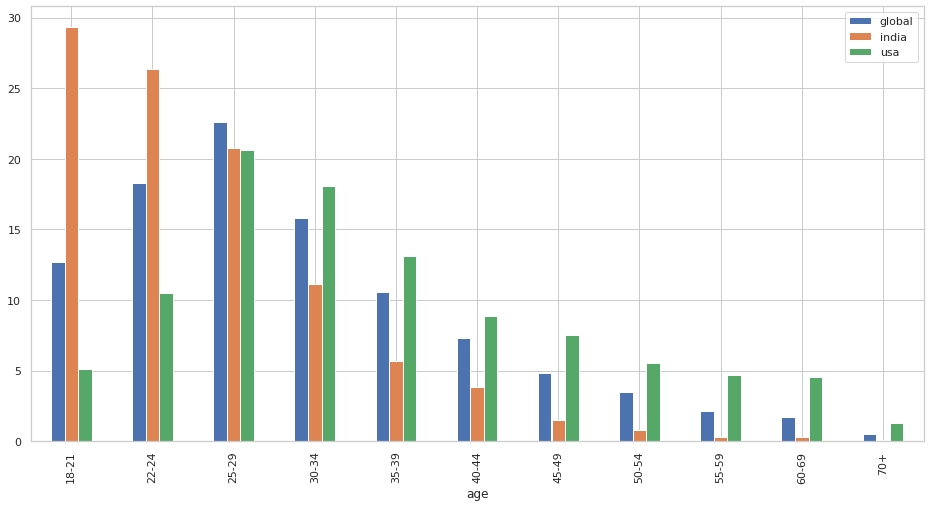

In [423]:
fig, ax = plt.subplots(figsize=(16, 8))
df_age.plot(kind="bar", ax=ax);

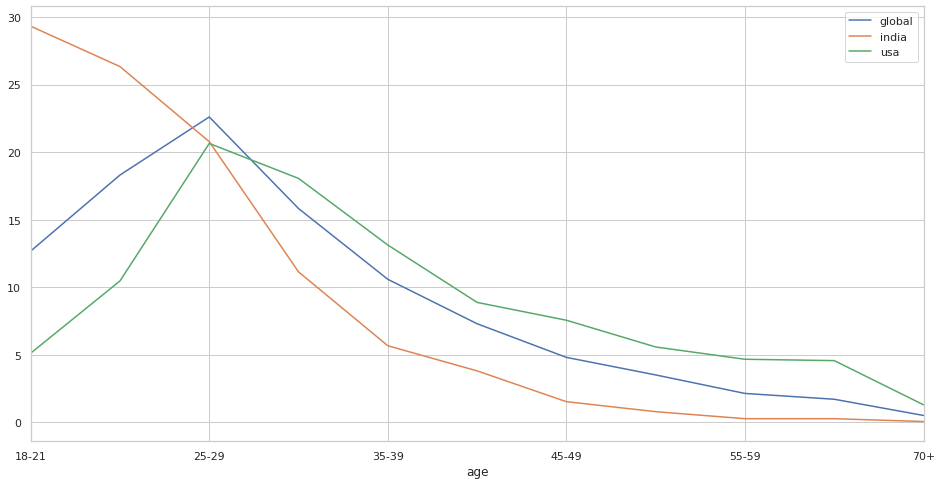

In [424]:
fig, ax = plt.subplots(figsize=(16, 8))
df_age.plot(kind="line", ax=ax);

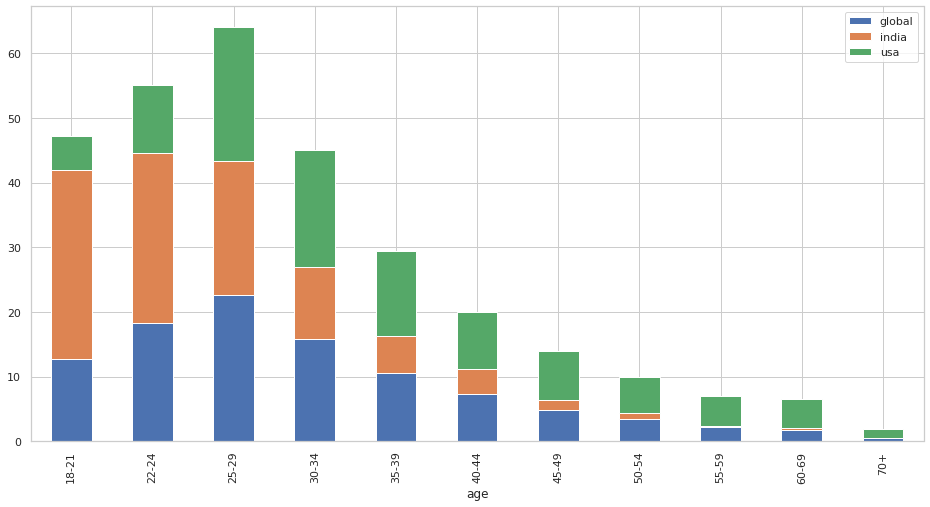

In [425]:
fig, ax = plt.subplots(figsize=(16, 8))
df_age.plot(kind="bar", ax=ax, stacked=True);

## Development of technical resources

In [427]:
# company size

global_company_size_dist = perc(df, "company_size").rename(columns={"company_size" : "global"})
india_company_size_dist = perc(india, "company_size").rename(columns={"company_size" : "india"})
usa_company_size_dist = perc(usa, "company_size").rename(columns={"company_size" : "usa"})
df_company_size = global_company_size_dist.merge(right=india_company_size_dist, how="inner", left_index=True, right_index=True)
df_company_size = df_company_size.merge(right=usa_company_size_dist, how="inner", left_index=True, right_index=True)
df_company_size = df_company_size.reset_index().rename(columns={"index" : "company_size"}).sort_values("company_size").set_index("company_size")
df_company_size = df_company_size.reindex(index = ["0-49 employees", "50-249 employees", "250-999 employees", "1000-9,999 employees", "> 10,000 employees"])
df_company_size

,global,india,usa
company_size,,,
0-49 employees,28.75,26.27,20.43
50-249 employees,16.63,14.97,14.38
250-999 employees,13.19,11.37,11.03
"1000-9,999 employees",18.86,13.90,22.61
"> 10,000 employees",22.57,33.48,31.55


In [432]:
df_comp = df[(df["country"] == "India") | (df["country"] == "United States of America")]
df_comp["country"].value_counts()

India                       4783
United States of America    3084
Name: country, dtype: int64

In [435]:
list(df_comp["company_size"].value_counts().keys())

['> 10,000 employees',
 '0-49 employees',
 '1000-9,999 employees',
 '50-249 employees',
 '250-999 employees']

In [450]:
def undummy(df, col_pattern, labels_only=False):
    df_tmp = df.loc[:,df.columns.str.contains(col_pattern)]
    cols_to_bool = list(df_tmp.columns)

    df_tmp = df_tmp.fillna(0)

    labels = []
    for col in cols_to_bool:
        labels.append(df_tmp[col].value_counts().keys()[1])


    for col in cols_to_bool:
        df_tmp[col] = np.where(df_tmp[col] != 0, 1, 0)
        df_tmp[col] = df_tmp[col].astype(int)

    resources = []
    for col in cols_to_bool:
        resources.append(df_tmp[col].sum())

    labels

    resources = pd.DataFrame(data=resources, index=labels)
#     resources = resources.drop("6")
    resources = resources.rename(columns={0: "value"})
    resources = resources.sort_values(by="value", ascending=False)
    
    if labels_only == True:
        return labels
    return resources


resources_india = undummy(india, "Q13")
resources_usa = undummy(usa, "Q13")

resources = resources_india.merge(right=resources_usa, how="inner", left_index=True, right_index=True)
resources = resources.rename(columns={"value_x": "india", "value_y": "usa"})


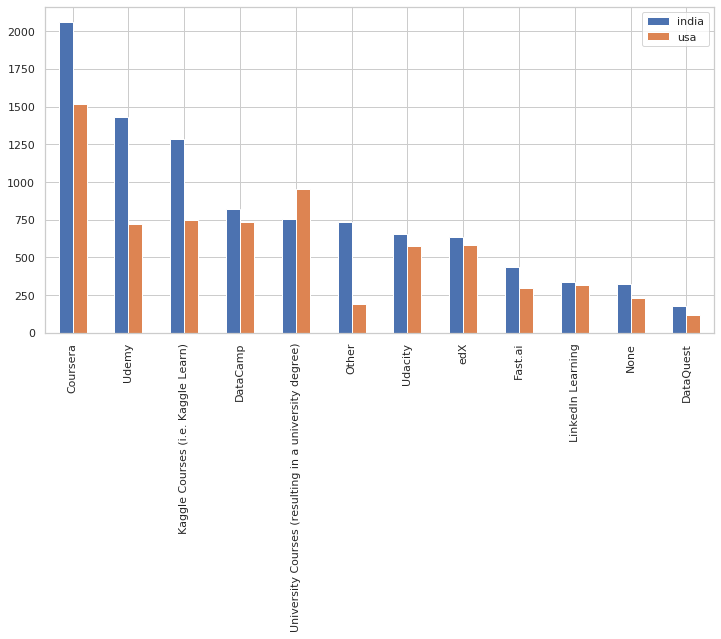

In [464]:
labels = undummy(india, "Q13", labels_only=True)
labels[5] = "Kaggle Courses"
labels[9] = "University Courses"

fig, ax = plt.subplots(figsize=figure_size)
ax.set_xticklabels(labels)
resources.plot(kind="bar", ax=ax)
plt.show()

In [467]:
india_tools_dist = perc(india, "Q14").rename(columns={"Q14": "india"})
usa_tools_dist = perc(usa, "Q14").rename(columns={"Q14": "usa"})
df_tools = india_tools_dist.merge(right=usa_tools_dist, how="inner", left_index=True, right_index=True)

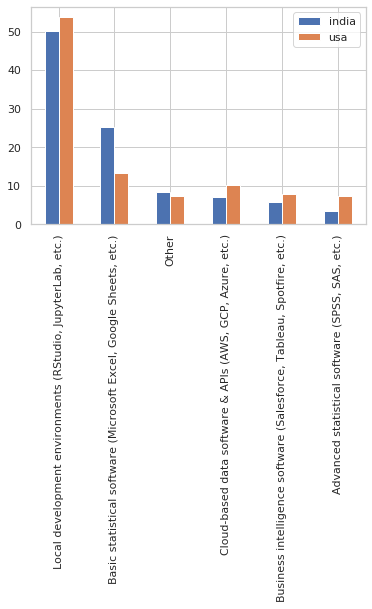

In [468]:
df_tools.plot(kind="bar");